# Load and preprocess image

/tmp/ipykernel_6198/2438612561.py:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)


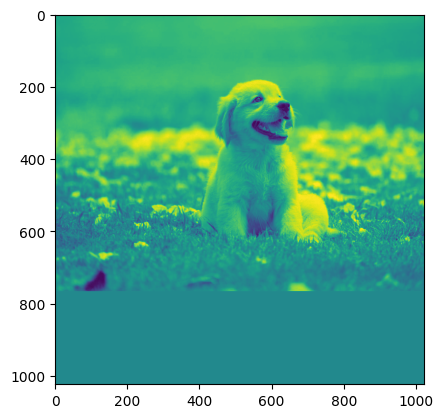

In [1]:
import PIL.Image
import numpy as np
import torch
import matplotlib.pyplot as plt

inference_size = 1024
image_mean = torch.tensor([123.675, 116.28, 103.53])[:, None, None]
image_std = torch.tensor([58.395, 57.12, 57.375])[:, None, None]

image_pil = PIL.Image.open("../assets/dog.jpg")
aspect_ratio = image_pil.width / image_pil.height
if aspect_ratio >= 1:
    resize_width = inference_size
    resize_height = int(inference_size / aspect_ratio)
else:
    resize_height = inference_size
    resize_width = int(inference_size * aspect_ratio)

image_pil_resized = image_pil.resize((resize_width, resize_height))
image_np_resized = np.asarray(image_pil_resized)
image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)
image_torch_resized_normalized = (image_torch_resized.float() - image_mean) / image_std
image_tensor = torch.zeros((1, 3, 1024, 1024))
image_tensor[0, :, :resize_height, :resize_width] = image_torch_resized_normalized


plt.imshow(image_tensor[0,0])
plt.show()

# Load Image Encoder

In [37]:
import tensorrt as trt
from torch2trt import TRTModule

with trt.Logger() as logger, trt.Runtime(logger) as runtime:
    with open("../data/mobile_sam_image_encoder.engine", 'rb') as f:
        engine_bytes = f.read()
    engine = runtime.deserialize_cuda_engine(engine_bytes)

input_name = engine.get_binding_name(0)
output_name = engine.get_binding_name(1)

image_encoder_trt = TRTModule(
    engine=engine,
    input_names=[engine.get_binding_name(0)],
    output_names=[engine.get_binding_name(1)]
)

/tmp/ipykernel_5411/1090541712.py:9: DeprecationWarning: Use get_tensor_name instead.
  input_name = engine.get_binding_name(0)
/tmp/ipykernel_5411/1090541712.py:10: DeprecationWarning: Use get_tensor_name instead.
  output_name = engine.get_binding_name(1)
/tmp/ipykernel_5411/1090541712.py:14: DeprecationWarning: Use get_tensor_name instead.
  input_names=[engine.get_binding_name(0)],
/tmp/ipykernel_5411/1090541712.py:15: DeprecationWarning: Use get_tensor_name instead.
  output_names=[engine.get_binding_name(1)]


# Load Mask Decoder

In [38]:
import tensorrt as trt
from torch2trt import TRTModule

with trt.Logger() as logger, trt.Runtime(logger) as runtime:
    with open("../data/mobile_sam_mask_decoder.engine", 'rb') as f:
        engine_bytes = f.read()
    engine = runtime.deserialize_cuda_engine(engine_bytes)

input_names = [
    "image_embeddings",
    "point_coords",
    "point_labels",
    "mask_input",
    "has_mask_input",
    "orig_im_size"
]

output_names = [
    "masks",
    "iou_predictions",
    "low_res_masks"
]


mask_decoder_trt = TRTModule(
    engine=engine,
    input_names=input_names,
    output_names=output_names
)

# Run Inference

In [2]:
image_tensor = image_tensor.float().cuda()

In [3]:
import time

In [45]:

torch.cuda.current_stream().synchronize()
t0 = time.monotonic()
for i in range(20):
    features = image_encoder_trt(image_tensor)
torch.cuda.current_stream().synchronize()
t1 = time.monotonic()

print(20 / (t1 - t0))

10.15821874175648


In [42]:
features = image_encoder_trt(image_tensor)

In [4]:

from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
mobile_sam = sam_model_registry["vit_t"](checkpoint="../weights/mobile_sam.pt")
mobile_sam.to(device="cuda")
mobile_sam.eval()

/home/jetson/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jetson/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jetson/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [9]:
with torch.no_grad():
    features_orig = mobile_sam.image_encoder(image_tensor)

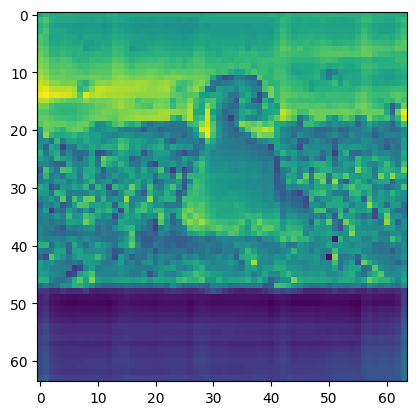

In [10]:
plt.imshow(features_orig[0, 40].detach().cpu())

In [43]:
features.shape

torch.Size([1, 256, 64, 64])